_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: Madhavi Sen, Kübra Ozdemir, Lalitha Sivakumar

# Coding Lab 8



In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rc("savefig", dpi=72)
sns.set_style("whitegrid")
%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-06-30 22:09:42W. Europe Daylight Time

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.4.0

sklearn: 1.1.1

numpy     : 1.23.0
matplotlib: 3.5.2
seaborn   : 0.11.2

Watermark: 2.4.3



# Task 1: Implement entropy estimators


*Grading: 5 pts (basic) + 1 pts (advanced) + 3 pts (bonus)*

## General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$ s and $0$ s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


## Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


## Basic
*Grading: 5 pts*

### MLE

*Grading: 1 pts*

$H_{ML}= -\sum_{x}\hat{p}(x)log(\hat{p}(x))$

In [3]:
def entropy_mle(phat):
    """Maximum likelihood or plug-in estimator of discrete entropy

    Parameter
    ---------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    Return
    ------
    H: float
        Entropy estimate
    """
    # insert your code here (1 pt)

    filtered = phat[phat > 0]

    H = -np.sum(filtered * np.log2(filtered))

    return H

### Miller-Maddow corrected

*Grading: 1 pts*

$H_{MM}=H_{ML}+\frac{\hat{d}-1}{2n}$ 

$ \hat{d} = \#[\hat{p}(x)>0]$ 



In [4]:
def entropy_mm(phat, n):
    """Miller-Maddow corrected estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n:  int
        Number of samples


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)

    k = np.count_nonzero(phat)
    H = entropy_mle(phat) + (k - 1) / (2 * n)
    return H

### Jack-knife corrected

*Grading: 2 pts*

$\hat{H}_{JK} = N\hat{H}_{ML} - (N-1)\hat{H}_{ML}^{(.)}$ 

$\hat{H}_{ML}^{(.)} = <H_{ML}^{\lnot i}>$

In [5]:
def entropy_jk(x, edges):
    """Jack-knife corrected estimator of discrete entropy

    Parameters
    ----------
    x: np.array, shape=(n_samples, )
        Samples

    edges: np.array, shape=(n_bins, )
        Histogram bin edges


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (2 pt)

    N = len(x)

    # Calculate the full sample entropy (H_ML)
    hist, _ = np.histogram(x, bins=edges)
    p = hist / N
    H_ML = -np.sum(p[p > 0] * np.log2(p[p > 0]))

    # Calculate the leave-one-out entropies
    H_ML_i = np.zeros(N)
    for i in range(N):
        hist_i, _ = np.histogram(np.delete(x, i), bins=edges)
        p_i = hist_i / (N - 1)
        H_ML_i[i] = -np.sum(p_i[p_i > 0] * np.log2(p_i[p_i > 0]))

    # Calculate the average leave-one-out entropy
    H_ML_dot = np.mean(H_ML_i)

    # Calculate the Jack-knife corrected entropy
    H = N * H_ML - (N - 1) * H_ML_dot

    # insert your code here (2 pt)
    data_length = np.size(x)
    if data_length > 1000:
        index_array = np.arange(0, data_length)
        np.random.shuffle(index_array)
        selected_indices = index_array[:1000]
        selected_count = 1000
    else:
        selected_indices = np.arange(0, data_length)
        selected_count = data_length
    entropy_values = []
    for index in selected_indices:
        # Exclude current index from the data
        modified_data = np.delete(x.copy(), int(index))
        # Estimate probability distribution
        hist_values = np.histogram(modified_data, edges)[0]
        prob_estimate = hist_values / np.size(modified_data)
        entropy_value = entropy_mle(prob_estimate)
        entropy_values.append(entropy_value)
    # Estimate probability distribution for all data
    full_hist_values = np.histogram(x, edges)[0]
    full_prob_estimate = full_hist_values / data_length
    # Calculate entropy for full data
    full_entropy = entropy_mle(full_prob_estimate)
    H = selected_count * full_entropy - (selected_count - 1) * np.mean(entropy_values)

    return H

### Coverage-adjusted

*Grading: 1 pts*

$C = 1 - \frac{\# f_{i}=1}{N}$

$\hat{P}_{C}= \hat{P}\cdot C$ 

$H_{CA}= -\sum_{x}\frac{\hat{P_{C}}(x)log(\hat{P_{C}}(x))}{1-(1-\hat{P_{C}}(x))^N}$



In [6]:
def entropy_cae(phat, n):
    """coverage-adjusted estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n: int
        Number of samples.


    Return
    ------

    H: float
        Entropy estimate
    """

    # Calculate coverage
    C = 1 - np.count_nonzero(phat == 1) / n
    # Adjust probabilities
    P_C = phat * C
    d = 1 - (1 - P_C) ** n
    d[d == 0] = 1
    # Calculate entropy
    H = -np.sum(np.divide(np.array([p * np.log2(p) if p != 0 else 0 for p in P_C]), d))

    return H

## Advanced
*Grading: 1 + 3 pts*

### JVHW
*Grading: 1 pts*

In [7]:
def entropy_jvhw(x):
    """JVHW estimator of discrete entropy.

    Parameter
    ---------
    x: np.array, shape=(n_samples, )
        Samples

    Return
    ------
    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)

    _, counts = np.unique(
        x, return_counts=True
    )  # note: tried to use entro.py package, but had technical difficulties in running
    pr = counts / counts.sum()  # empirical dist

    # calculate the jvhw entropy
    n = len(x)
    k = len(pr)

    def V(p, n):  # aux
        if p == 0 or p == 1:
            return 0
        return p * (1 - p) / (n * (1 - 1 / n))

    H = 0
    for p in pr:
        H += V(p, n)

    return -H

### Bonus points: Unseen or Best Upper Bounds estimator
*Grading: 3 bonus pts*

In [8]:
# insert your code here

# ------------------------------------------
# Port Unseen or Best Upper Bounds estimator
# from MatLab to Python. (3 bonus pts)

# !pip install mysql-connector-python datajoint numpy

# Since no additional context is given, and an unseen/best estimator depends on several aspects about the underlying data distribution, I will
np.random.seed(0)

# Example variables
var1 = np.random.randint(0, 20, size=100)
var2 = np.random.choice(["category1", "category2", "category3"], size=100)
var3 = np.random.rand(100) * 10
print("var1:", var1[:10])
print("var2:", var2[:10])
print("var3:", var3[:10])


def entropy_paninski(data):
    """

    data : np.array, shape=(n_samples, )
        Array of discrete values (e.g., int/categorical).

    returns
    -------
    float
        Estimated entropy of the data.
    """
    n = len(data)

    _, counts = np.unique(data, return_counts=True)
    p_hat = counts / n
    H = -np.sum(p_hat * np.log2(p_hat))  # P entropy
    return H


# Ex : H for var1
v1 = entropy_paninski(var1)
print("H(var1):", v1)

# _, v2e = np.unique(var2, return_inverse=True)
# v2 = entropy_paninski(v2e)
# print("H(var2):", v2)

# v3 = entropy_paninski(var3)
# print("H(var3):", v3)

var1: [12 15  0  3  3  7  9 19 18  4]
var2: ['category2' 'category1' 'category2' 'category2' 'category1' 'category3'
 'category3' 'category3' 'category3' 'category2']
var3: [4.31418435 8.96546596 3.6756187  4.35864925 8.91923355 8.06193989
 7.03888584 1.00226887 9.19482614 7.142413  ]
H(var1): 4.2124674171731975


# Task 2: Distributions
*Grading: 4 pts*

## Uniform distribution
*Grading: 2 pts*

In [9]:
D = 10
N = 2**D

p = 1 / N * np.ones(N)  # true distribution

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (2 pt)

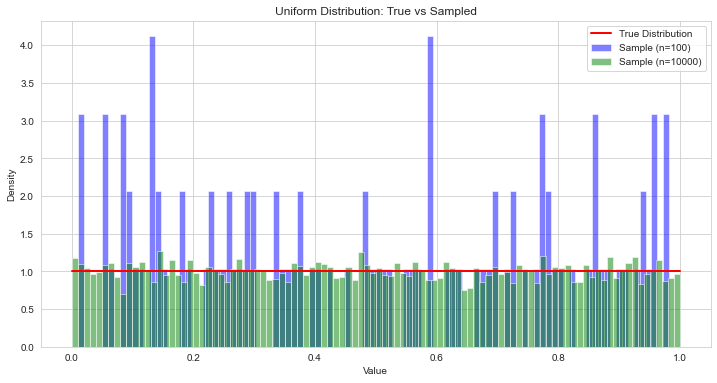

In [10]:
# insert your code here
rng = np.random.default_rng(0)

min_val = 0
max_val = 1
# ------------------------------------
# Sample from the uniform distribution
# using sample size of 100 (0.5 pts)
# ------------------------------------
sample_100 = np.random.uniform(min_val, max_val, 100)

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 10000 (0.5 pts)
# ------------------------------------
sample_10000 = np.random.uniform(min_val, max_val, 10000)


# ------------------------------------
# Plot the true distribution and
# the sampled distributions. (0.5 pts)
# ------------------------------------
# Plot all distributions in one graph
plt.figure(figsize=(12, 6))

# True distribution
plt.plot([min_val, max_val], [1, 1], "r-", label="True Distribution", linewidth=2)

# Sample size 100
plt.hist(
    sample_100, bins=100, density=True, alpha=0.5, label="Sample (n=100)", color="blue"
)

# Sample size 10000
plt.hist(
    sample_10000,
    bins=100,
    density=True,
    alpha=0.5,
    label="Sample (n=10000)",
    color="green",
)

plt.title("Uniform Distribution: True vs Sampled")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In smaller sample sizes (n = 100 in our case), we don't see a very uniform distribution. However, as we increased the sample size (n = 100000), we are approaching to the true distribution and see less deviation as a result of law of large numbers.

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [11]:
sample_sizes = np.round(np.logspace(1, 5, num=10))
n_runs = 30
rng = np.random.default_rng(1)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):

        # ------------------------------------
        # Sample from the uniform distribution
        # with different sample size (0.5 pts)
        # ------------------------------------

        # insert your code here

        x = np.random.randint(0, N, int(S))
        hist = np.histogram(x, edges)[0]
        phat = hist / S

        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        # h_jk[i, j] = entropy_jk(x, edges)
        # h_jvhw[i, j] = entropy_jvhw(x)

Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

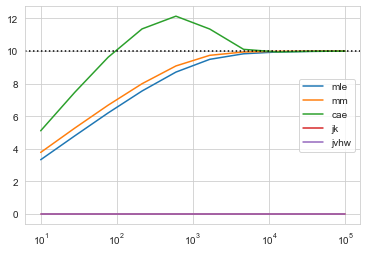

In [12]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color="black", linestyle=":")

plt.legend()

## Zipf distribution
*Grading: 2 pts*

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (2 pts)

In [13]:
D = 10
N = 2**D

p = 1 / (np.arange(0, N) + 1)  # true distribution
p = p / np.sum(p)

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `choice` of numpys random number generator is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? 

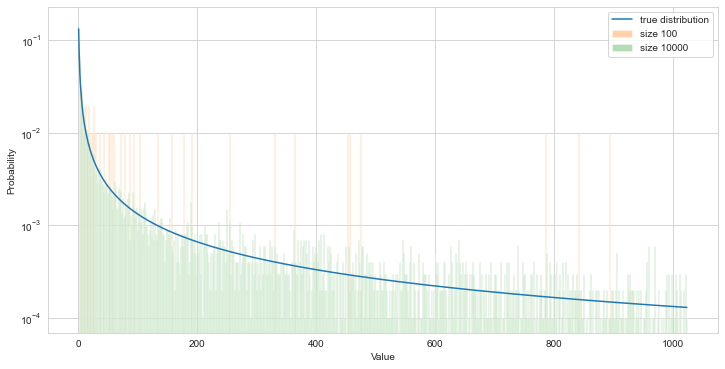

In [14]:
# insert your code here
rng = np.random.default_rng(2)

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 100 (0.5 pts)
# ---------------------------------------
D = 10  # params
N = 2**D
p_zipf = 1 / (np.arange(1, N + 1))  # with d=1
p_zipf = p_zipf / np.sum(p_zipf)  # normalize

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 10000 (0.5 pts)
# ---------------------------------------
sample_100 = rng.choice(np.arange(1, N + 1), size=100, p=p_zipf)
sample_10000 = rng.choice(np.arange(1, N + 1), size=10000, p=p_zipf)

# ---------------------------------------
# Plot the true distribution and the sampled
# distributions. (0.5 pts)
# ---------------------------------------

plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, N + 1), p_zipf, label="true distribution")
bins = np.arange(1, N + 2)
plt.hist(sample_100, bins, alpha=0.35, density=True, label="size 100")
plt.hist(sample_10000, bins, alpha=0.35, density=True, label="size 10000")

plt.xlabel("Value")
plt.ylabel("Probability")
plt.yscale("log")
plt.legend()
plt.show()

The sample size= 10000 better approximates the true Zipf distribution than the sample size=100 (as per LLN). 

But still, both samples don't seem to capture much of the distribution's tail, especially for larger values with very low probabilities. This feature is typical of Zipf and other heavy-tailed distributions, where a few elements are very common while others are rare.

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [15]:
sample_sizes = np.round(np.logspace(1, 5, num=10))
n_runs = 30
rng = np.random.default_rng(3)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them

v1 = np.zeros((len(sample_sizes), n_runs))

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):

        # ---------------------------------------
        # Sample from the Zipf distribution
        # with different sample size (0.5 pts)
        # ---------------------------------------

        # insert your code here
        x = np.random.choice(np.arange(N), size=int(S), p=p)
        hist = np.histogram(x, edges)[0]
        phat = hist / S

        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        h_jk[i, j] = entropy_jk(x, edges)
        h_jvhw[i, j] = entropy_jvhw(x)

In [16]:
D = 10
N = 2**D

# True Zipf distribution
p_zipf = 1 / (np.arange(1, N + 1))  # Zipf's law with d=1
p_zipf = p_zipf / np.sum(p_zipf)  # Normalize to make it a probability distribution

# Parameters for evaluation
sample_sizes = np.round(np.logspace(1, 5, num=10)).astype(
    int
)  # Logarithmically spaced sample sizes
n_runs = 30  # Number of runs
rng = np.random.default_rng(3)

# Arrays to store entropy estimates
h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))

# Loop over sample sizes and runs
for i, S in enumerate(sample_sizes):
    for j in range(n_runs):
        # Sample from the Zipf distribution with size S
        samples = rng.choice(np.arange(1, N + 1), size=S, p=p_zipf)

        # Estimate entropy using different estimators
        phat = np.bincount(samples, minlength=N + 1)[1:] / S  # Empirical distribution

        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        h_jk[i, j] = entropy_jk(samples, np.arange(-0.5, N, 1))
        h_jvhw[i, j] = entropy_jvhw(samples)

# Plotting results
plt.figure(figsize=(12, 8))

# Plotting entropy estimates for each estimator
plt.errorbar(
    sample_sizes,
    np.mean(h_mle, axis=1),
    yerr=np.std(h_mle, axis=1),
    fmt="-o",
    label="MLE",
)
plt.errorbar(
    sample_sizes,
    np.mean(h_mm, axis=1),
    yerr=np.std(h_mm, axis=1),
    fmt="-s",
    label="Miller-Madow",
)
plt.errorbar(
    sample_sizes,
    np.mean(h_cae, axis=1),
    yerr=np.std(h_cae, axis=1),
    fmt="-^",
    label="Chao-Entropy",
)
plt.errorbar(
    sample_sizes,
    np.mean(h_jk, axis=1),
    yerr=np.std(h_jk, axis=1),
    fmt="-d",
    label="Miller-Jackknife",
)
plt.errorbar(
    sample_sizes,
    np.mean(h_jvhw, axis=1),
    yerr=np.std(h_jvhw, axis=1),
    fmt="-p",
    label="JVHW",
)

plt.xscale("log")  # Logarithmic scale for x-axis
plt.xlabel("Sample Size")
plt.ylabel("Estimated Entropy")
plt.title("Entropy Estimation with Different Sample Sizes")
plt.legend()
plt.grid(True)
plt.show()

Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

In [ ]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")

# plot h_unseen or h_bub here if you implemented them.
plt.semilogx(sample_sizes, np.mean(v1, axis=1), label="jvhw")

plt.axhline(H, color="black", linestyle=":")
plt.legend()